In [1]:
import tensorflow as tf
import os
import sys
import glob
import random
import shutil
import numpy as np
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from tqdm import trange
from math import ceil

%matplotlib inline

In [2]:
class TFRecordGenerator:
    
    def __init__(self):
        pass
    
    def convert(self,
                directory,
                tfrecord_file_name,
                suffix='tfrecord',
                num_files_per_record=1000,
                shuffle=True,
                encode_image_shape=False):
        
        image_paths = get_image_paths(get_subdirectories(directory))
        
        if shuffle:
            random.shuffle(image_paths)
            
        num_files_total = len(image_paths)
        num_tfrecords = ceil(num_files_total / num_files_per_record)
        start = 0
        tfrecord_file_number = 0
        
        while start < num_files_total:
            num_files_remaining = num_files_total - start
            batch_size = num_files_per_record if (num_files_remaining >= num_files_per_record) else num_files_remaining
            with tf.python_io.TFRecordWriter(tfrecord_file_name + '_{:04d}.{}'.format(tfrecord_file_number, suffix)) as writer:
                for i in trange(batch_size, desc="Creating TFRecord file {}/{}".format(tfrecord_file_number+1, num_tfrecords), file=sys.stdout):
                    example = self._convert_sample(image_paths[start+i], encode_image_shape) # This is an instance of tf.Example
                    writer.write(example.SerializeToString())
            start += num_files_per_record
            tfrecord_file_number += 1
                
    def _convert_sample(self, image_path, encode_image_shape=False):
        
        # Convert the image.
        image_feature = self._convert_image(image_path, encode_image_shape)
        
        # Convert the label.
        label_feature = self._convert_image_class_from_file_name(image_path)
        
        return tf.train.Example(features = tf.train.Features(feature = {**image_feature, **label_feature}))
    
    def _convert_image(self, image_path, encode_image_shape=False):
        '''
        Converts an image and returns a dictionary of `tf.train.Feature` objects,
        which is the input to `tf.train.Features`.
        '''
        
        file_name = os.path.basename(image_path)
        
        # Read a byte representation of the image.
        with tf.gfile.GFile(image_path, 'rb') as fid:
            image = fid.read()
            
        if encode_image_shape:
            image_shape = mpimg.imread(image_path).shape
            if len(image_shape) == 2:
                image_shape += (1,)
            return {
                'image': tf.train.Feature(bytes_list = tf.train.BytesList(value = [image])),
                'filename': tf.train.Feature(bytes_list = tf.train.BytesList(value = [file_name.encode('utf-8')])),
                'height': tf.train.Feature(int64_list = tf.train.Int64List(value = [image_shape[0]])),
                'width': tf.train.Feature(int64_list = tf.train.Int64List(value = [image_shape[1]])),
                'channels': tf.train.Feature(int64_list = tf.train.Int64List(value = [image_shape[2]]))
            }
               
        return {
            'image': tf.train.Feature(bytes_list = tf.train.BytesList(value = [image])),
            'filename': tf.train.Feature(bytes_list = tf.train.BytesList(value = [file_name.encode('utf-8')]))
        }
            
    def _convert_image_class_from_file_name(self, image_path):
        
        label = get_image_class_from_file_name(image_path)
        return {
            'label': tf.train.Feature(int64_list = tf.train.Int64List(value = [label]))
        }

In [26]:
input_directory = '/pierluigiferrari/datasets/256_ObjectCategories/'
output_file = '/pierluigiferrari/datasets/Caltech256/Caltech256'
extract_directory = '/pierluigiferrari/datasets/Extracted_TFRecords/'

In [27]:
tfrecord_generator = TFRecordGenerator()

tfrecord_generator.convert(input_directory, output_file, num_files_per_record=3070, encode_image_shape=False)

Creating TFRecord file 10/10: 100%|██████████| 2977/2977 [00:01<00:00, 1863.82it/s]


In [3]:
def get_subdirectories(directory, include_top=True):
    '''
    Return a list of all subdirectories of `directory`.
    '''
    
    subdirectories = []
    
    if include_top:
        subdirectories.append(directory)
    
    for dirpath, dirnames, filenames in os.walk(top=directory, topdown=True):
        
        subdirs = [os.path.join(dirpath, dirname) for dirname in dirnames]
        subdirectories += subdirs
        
    return subdirectories

In [4]:
def get_image_paths(directories, extensions=['jpg','jpeg','png']):
    '''
    Return a list of all image paths in `directories`.
    
    Arguments:
        directories (list): A list of directory paths to iterate over.
        extensions (list, optional): An optional list of strings that
            define all acceptable file extensions. If `None`, any file
            extension is acceptable.
    '''
    
    image_paths = []
    
    if extensions is None:
    
        for directory in directories:

            image_paths += glob.glob(os.path.join(directory, '*'))
            
    else:
            
        for directory in directories:
            
            for extension in extensions:

                image_paths += glob.glob(os.path.join(directory, '*.'+extension))
                
    return image_paths

In [5]:
def get_image_class_from_file_name(image_path, separator='_'):
    '''
    Return the class ID of an image (i.e. an integer) based on the beginning of the
    image name string
    '''
    
    return int(os.path.basename(image_path).split(separator)[0])

In [6]:
class TFRecordExtractor:
    
    def __init__(self, tfrecord_file):
        self.tfrecord_file = os.path.abspath(tfrecord_file)

    def _extract_fn(self, tfrecord):
        
        # Extract features using the keys set during creation
        features = {
            'filename': tf.FixedLenFeature([], tf.string),
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        }

        # Extract the data record
        sample = tf.parse_single_example(tfrecord, features)

        image = tf.image.decode_image(sample['image'])
        label = sample['label']
        filename = sample['filename']
        return [image, label, filename]

    def extract_image(self):
        # Create folder to store extracted images
        folder_path = extract_directory
        shutil.rmtree(folder_path, ignore_errors = True)
        os.mkdir(folder_path)

        # Pipeline of dataset and iterator
        dataset = tf.data.TFRecordDataset([self.tfrecord_file])
        dataset = dataset.map(self._extract_fn)
        iterator = dataset.make_one_shot_iterator()
        next_image_data = iterator.get_next()

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            try:
                return sess.run(next_image_data)
            except tf.errors.OutOfRangeError:
                print('nooo!')

In [36]:
tfrecord_file = '/pierluigiferrari/datasets/Caltech256/Caltech256_0000.tfrecord'

tfrecord_extractor = TFRecordExtractor(tfrecord_file)

sample = tfrecord_extractor.extract_image()

196 b'196_0054.jpg'


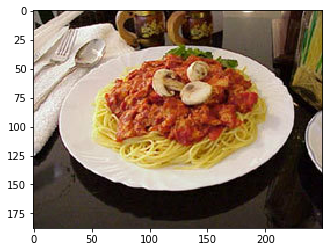

In [39]:
print(sample[1], sample[2])
plt.imshow(sample[0])

In [129]:
class UnpackFeaturesLabels:
    
    def __init__(self, num_parallel_calls=None):
        self.num_parallel_calls = num_parallel_calls
    
    def __call__(self, dataset):
        dataset = dataset.map(lambda sample: (sample['image'], sample['label']),
                              num_parallel_calls=self.num_parallel_calls)
        return dataset

class DecodeImages:
    
    def __init__(self,
                 channels=3,
                 num_parallel_calls=None):
        
        self.channels = channels
        self.num_parallel_calls = num_parallel_calls
    
    def __call__(self, dataset):
        dataset = dataset.map(lambda image, label: (tf.image.decode_image(image, channels=self.channels), label),
                              num_parallel_calls=self.num_parallel_calls)
        return dataset
                              
class DecodeJPEGImages:
    
    def __init__(self,
                 channels=None,
                 ratio=1,
                 num_parallel_calls=None):
        
        self.channels = channels
        self.ratio = ratio
        self.num_parallel_calls = num_parallel_calls
    
    def __call__(self, dataset):
        dataset = dataset.map(lambda image, label: (tf.image.decode_image(image,
                                                                          channels=self.channels,
                                                                          ratio=self.ratio), label),
                              num_parallel_calls=self.num_parallel_calls)
        return dataset
    
class RandomCrop:
    
    def __init__(self,
                 aspect_ratio=1,
                 scale=0.9,
                 channels=3,
                 num_parallel_calls=None):
        
        self.aspect_ratio = aspect_ratio
        self.scale = scale
        self.channels = channels
        self.num_parallel_calls = num_parallel_calls
        
    def __call__(self, dataset):
        
        def _inner(image, label):
            
            side_length = tf.to_int32(tf.to_float(tf.minimum(tf.shape(image)[0], tf.shape(image)[1])) * tf.constant(self.scale))
            
            if self.channels == 1:
                crop_size = [side_length, side_length]
            else:
                crop_size = [side_length, side_length, tf.shape(image)[2]]
            
            return (tf.image.random_crop(image, size=crop_size), label)
        
        dataset = dataset.map(_inner,
                              num_parallel_calls=self.num_parallel_calls)
        return dataset
    
class Resize:
    
    def __init__(self,
                 target_size,
                 preserve_aspect_ratio=False,
                 num_parallel_calls=None):
        
        self.target_size = target_size
        self.preserve_aspect_ratio = preserve_aspect_ratio
        self.num_parallel_calls = num_parallel_calls
        
    def __call__(self, dataset):
        dataset = dataset.map(lambda image, label: (tf.image.resize_images(image,
                                                                           size=self.target_size,
                                                                           preserve_aspect_ratio=self.preserve_aspect_ratio), label),
                              num_parallel_calls=self.num_parallel_calls)
        return dataset
    
class ResizeWithPad:
    
    def __init__(self,
                 target_size,
                 num_parallel_calls=None):
        
        self.target_size = target_size
        self.num_parallel_calls = num_parallel_calls
        
    def __call__(self, dataset):
        dataset = dataset.map(lambda image, label: (tf.image.resize_image_with_pad(image,
                                                                                   target_height=self.target_size[0],
                                                                                   target_width=self.target_size[1],), label),
                              num_parallel_calls=self.num_parallel_calls)
        return dataset
    
class RandomFlipLeftRight:
    
    def __init__(self, num_parallel_calls=None):
        self.num_parallel_calls = num_parallel_calls
        
    def __call__(self, dataset):
        dataset = dataset.map(lambda image, label: (tf.image.random_flip_left_right(image), label),
                              num_parallel_calls=self.num_parallel_calls)
        return dataset
    
class ConvertLabelsToOneHot:
    
    def __init__(self, num_classes, num_parallel_calls=None):
        self.num_classes = num_classes
        self.num_parallel_calls = num_parallel_calls
        
    def __call__(self, dataset):
        dataset = dataset.map(lambda image, label: (image, tf.one_hot(indices=label,
                                                                      depth=self.num_classes)),
                              num_parallel_calls=self.num_parallel_calls)
        return dataset

In [130]:
class TFRecordDatasetCreator:
    
    def __init__(self,
                 tfrecord_paths,
                 feature_schema,
                 batch_size,
                 preprocessors=None,
                 num_epochs=None,
                 shuffle=True,
                 shuffle_buffer_size=None,
                 num_parallel_reads=None,
                 num_parallel_calls=None):
        
        if len(tfrecord_paths) != len(set(tfrecord_paths)):
            raise ValueError('tfrecord_paths {} are not unique.'.format(tfrecord_paths))
        if len(tfrecord_paths) == 0:
            raise ValueError('No tfrecords_paths specified.')
        if shuffle and shuffle_buffer_size is None:
            raise ValueError('If using shuffle, please specify a shuffle buffer size.')
        
        self.tfrecord_paths = [os.path.abspath(tfrecord_path) for tfrecord_path in tfrecord_paths]
        self.feature_schema = feature_schema
        self.batch_size = batch_size
        self.preprocessors = preprocessors
        self.num_epochs = num_epochs
        self.shuffle = shuffle
        self.shuffle_buffer_size = shuffle_buffer_size
        self.num_parallel_reads = num_parallel_reads
        self.num_parallel_calls = num_parallel_calls
        
    def _process(self):
        
        # Shuffle the TFRecord file names.
        self.dataset = tf.data.Dataset.from_tensor_slices(self.tfrecord_paths)
        if self.shuffle:
            self.dataset = self.dataset.shuffle(len(self.tfrecord_paths))
            
        # Create one unified dataset from the TFRecord files.
        self.dataset = self.dataset.flat_map(lambda filename: tf.data.TFRecordDataset(filename,
                                                                                      num_parallel_reads=self.num_parallel_reads))
        
        # Deserialize tf.Example objects.
        self.dataset = self.dataset.map(lambda single_example_proto: tf.parse_single_example(single_example_proto, self.feature_schema),
                                        num_parallel_calls=self.num_parallel_calls)
        
        # Apply any preprocessing.
        for preprocessor in self.preprocessors or []:
            self.dataset = preprocessor(self.dataset)

        # Shuffle the dataset.
        if self.shuffle:
            self.dataset = self.dataset.shuffle(buffer_size=self.shuffle_buffer_size)
        
    def create_dataset(self):
        
        self._process()
        dataset = self.dataset.batch(self.batch_size)
        return dataset
    
    def create_input_function(self):
        
        def _input_function():
            
            self._process()
            dataset = self.dataset.repeat(self.num_epochs)
            dataset = dataset.batch(self.batch_size)
            
            iterator = dataset.make_one_shot_iterator()
            batch = iterator.get_next()
            return batch
        
        return _input_function
    
    def create_generator(self):
        
        self._process()
        dataset = self.dataset.batch(self.batch_size)
            
        iterator = dataset.make_one_shot_iterator()
        batch = iterator.get_next()
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            try:
                while True:
                    yield sess.run(batch)

            except tf.errors.OutOfRangeError:
                print("The generator has iterated over the dataset once and is no longer usable.")

In [131]:
def get_tfrecord_paths(directory, extension='tfrecord'):
    
    return glob.glob(os.path.join(directory, '*.'+extension))

In [132]:
tfrecords_directory = '/pierluigiferrari/datasets/Caltech256'

feature_schema_with_shape = {'image': tf.FixedLenFeature([], tf.string),
                             'filename': tf.FixedLenFeature([], tf.string),
                             'height': tf.FixedLenFeature([], tf.int64),
                             'width': tf.FixedLenFeature([], tf.int64),
                             'channels': tf.FixedLenFeature([], tf.int64),
                             'label': tf.FixedLenFeature([], tf.int64)}

feature_schema = {'image': tf.FixedLenFeature([], tf.string),
                  'filename': tf.FixedLenFeature([], tf.string),
                  'label': tf.FixedLenFeature([], tf.int64)}

In [139]:
unpack_features_labels = UnpackFeaturesLabels()
decode_images = DecodeImages(channels=3)
random_crop = RandomCrop(aspect_ratio=1,
                         scale=1.0,
                         channels=3,
                         num_parallel_calls=None)
resize = Resize(target_size=(224,224))
resize_with_pad = ResizeWithPad(target_size=(224,224))
random_flip_left_right = RandomFlipLeftRight()
convert_labels_to_one_hot = ConvertLabelsToOneHot(num_classes=257)

preprocessors = [unpack_features_labels,
                 decode_images,
                 random_flip_left_right,
                 resize_with_pad,
                 convert_labels_to_one_hot]

tfrecord_dataset_creator = TFRecordDatasetCreator(tfrecord_paths=get_tfrecord_paths(directory=tfrecords_directory, extension='tfrecord'),
                                                  feature_schema=feature_schema,
                                                  batch_size=32,
                                                  preprocessors=preprocessors,
                                                  num_epochs=None,
                                                  shuffle=True,
                                                  shuffle_buffer_size=10000,
                                                  num_parallel_reads=None,
                                                  num_parallel_calls=None)

data_generator = tfrecord_dataset_creator.create_generator()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


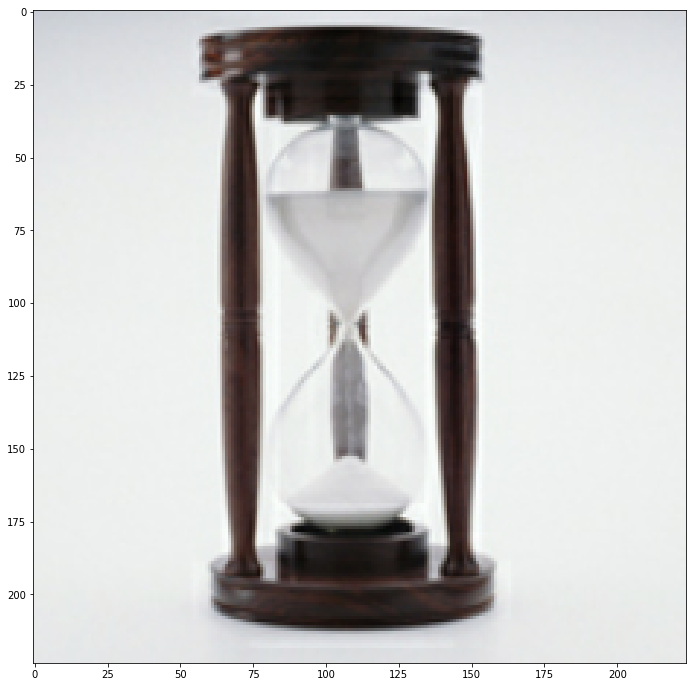

In [140]:
images, labels = next(data_generator)

print(labels[0])
plt.figure(figsize=(20,12))
plt.imshow(images[0].astype(np.uint8))